<a href="https://colab.research.google.com/github/Basel-byte/Network-Anomaly-Detection/blob/Kmean/Pr_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice Lab: Clustering  

In this exercise, we will know how K-Means and Normalized Cut algorithms can be used for network anomaly detection.

# Outline
- [ 1 - Extracting Dataset](#1)
- [ 2 - Packages ](#2)
- [ 3 - Reading data and Preprocessing](#3)
  - [3.1 Reading Columns' Names](#3.1)
  - [3.2 Reading dataset](#3.2)
  - [3.3 Removing class column](#3.3)
  - [3.4 Changing Categorical features to numericals](#3.4)
- [ 4 - K-means](#4)
- [ 5 - Spectral Clustering](#5)
  - [5.1 Getting Laplacian and Degree Matrices](#5.1)
  - [5.2 Spectral Clustering Algorithm](#5.2)
- [ 6 - New Clustering Algorithm](#6)
- [ 7 - Clustering Evaluation](#7)
  - [ 7.1 - Getting Predicted labels](#7.1)
  - [ 7.2 - Precision Measure](#7.2)
  - [ 7.3 - Recall Measure](#7.3)
  - [ 7.4 - F1 Measure](#7.4)
  - [ 7.5 - Entropy Measure](#7.5)
  

  

<a name="1"></a>
## 1 - Extracting Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gzip -d /content/drive/MyDrive/kddcup.data.gz

gzip: /content/drive/MyDrive/kddcup.data.gz: No such file or directory


<a name="2"></a>
## 2 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
<!-- - [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python. -->
<!-- - [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning. -->
- [pandas](https://pandas.pydata.org/) is open source data analysis and manipulation tool.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
from scipy.spatial.distance import cdist
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import eigh
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from scipy.spatial import KDTree

<a name="3"></a>
## 3 - Reading data and Preprocessing

<a name="3.1"></a>
#### Reading columns' names 

In [ ]:
DATASET_COLUMNS_FILE = "/home/elsaber/pr assign/cluster/kddcup1999_columns.txt"
column_types =[]

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[:]:
    match = column_regex.match(column_type)
    column_types.append(match.group("column_name"))
del column_labels


<a name="3.2"></a>
#### Reading the training dataset

In [ ]:
data = pd.read_csv("/home/elsaber/pr assign/cluster/kddcup.data.corrected", header=None)
data.columns = column_types

<a name="3.3"></a>
#### Removing class column

In [ ]:
data_without_labels = data.drop(columns=["class"])
labels = data["class"]
del data
del column_types

<a name="3.4"></a>
### Change the categorical features to numericals

In [ ]:
def convert_string_to_numeric(data_frame):
  # df_copy = data_frame.copy()
  my_dict = None
  for col in data_frame:
    if data_frame[col].dtypes == object:
      my_dict = {elem: index for index, elem in enumerate(data_frame[col].unique())}
      data_frame[col].replace(my_dict, inplace=True)
  return data_frame, my_dict

In [ ]:
def convert_string_to_binary_numeric(data_frame):
  # df_copy = data_frame.copy()
  for col in data_frame:
    if data_frame[col].dtypes == object:
      df1 = pd.get_dummies(data_frame[col])
      data_frame = pd.concat([data_frame, df1], axis=1).reindex(data_frame.index)
      data_frame.drop(col, axis=1, inplace=True)
  return data_frame

In [ ]:
# use either of them but not both
# convert_string_to_numeric(data_without_labels.copy())

data_without_labels = convert_string_to_binary_numeric(data_without_labels).values.astype(np.float32)

<a name="4"></a>
## 4 - Kmeans



In [ ]:
class new_KMeans:
    lables = None
    def __init__(self, k=2, max_iter=50,centroids = None):
        self.k = k
        self.max_iter = max_iter
        self.centroids = centroids
    def predict(self, array):
      distances = cdist(array, self.centroids)
      nearest_rows = np.argmin(distances, axis=1)
      return nearest_rows

    def compute_centroid(self,data_frame):
      data_unique = data_frame.values
      centroids = np.array([])
      shape = (0, data_unique.shape[1])  # 0 rows, 4 columns
      # Create empty numpy array
      centroids = np.empty(shape)
      # random intialization
      if self.centroids == None:
        while centroids.shape[0] < self.k:
          i = random.randint(0,len(data_unique)-1)
          centroids = np.vstack([centroids, data_unique[i]])
          # print(centroids.shape)
          if self.k == centroids.shape[0] :
            centroids = np.unique(centroids,axis=0)
        iter = 0
      nearest_rows = np.zeros((data_unique.shape[0]))
      while True:
        iter += 1
        distances = cdist(data_unique, centroids)
        # Find index of row with minimum distance for each row of arr1
        old_nearest = nearest_rows
        nearest_rows = np.argmin(distances, axis=1)
        clustering  = [[] for _ in range(self.k)]
        print(nearest_rows)
        # for i in range(len(nearest_rows)):
        #   clustering[nearest_rows[i]].append(data_unique[i])
        # old_centroids = centroids
        # centroids = np.empty(shape)
        # for i in clustering:
        #   new_centroid = np.mean(i, axis=0)
        #   centroids = np.vstack([centroids, new_centroid])
        old_centroids = centroids
        centroids = np.array([data_unique[nearest_rows == j].mean(axis=0) for j in range(self.k)])
        diff = np.abs(old_centroids - centroids)
        # print(diff)
        # Find the maximum difference
        max_diff = np.amax(diff)
        diff_near = np.abs(old_nearest - nearest_rows)
        diff_near = np.amax(diff_near)
        # print(diff)
        # Find the maximum difference
        max_diff = np.amax(diff)
        if max_diff < 1e-10 or diff_near == 0 or iter == self.max_iter:
          break
      # print(iter)
      print(f"Number of iterations = {iter}")
      return nearest_rows ,centroids
    def compute_error(self,data,predictions,centroids):
      distances = np.zeros(len(data))
      for i, (x, y) in enumerate(zip(data, predictions)):
        distances[i] = np.linalg.norm(x - centroids[y])
      mean_error = np.mean(distances)
      return mean_error
    def train(self,data_frame,k = 3):
      min_lables,min_centroids = self.compute_centroid(data_frame)
      min = self.compute_error(data_frame.values, min_lables, min_centroids)
      print(min)
      for i in range(1,k):
        lables,centroids= self.compute_centroid(data_frame)
        error = self.compute_error(data_frame.values, lables, centroids)
        if(error < min):
          min = error
          min_centroids = centroids
          min_lables = lables
      self.centroids = min_centroids
      self.lables = min_lables
      return self.lables

### Testing With diffrent k

In [ ]:
def test_with_k(K, data_without_strings):
    train = new_KMeans(K)
    st = time.time()
    lables= train.train(data_without_strings)
    total_time = time.time() - st
    kmean_data_frame = pd.DataFrame(lables)
    print(kmean_data_frame)
    kmean_data_frame.columns = ["labels"]
    counts = kmean_data_frame['labels'].value_counts()
    print("Kmean cluster result")
    print(counts)
    print(f"Time in seconds = {total_time}")
    kmeans = KMeans(n_clusters=K)
    # fit the KMeans object to the data
    st = time.time()
    kmeans.fit(data_without_strings.values)
    centroids = kmeans.cluster_centers_
    skLearn_labels =kmeans.predict(data_without_strings.values)
    total_time = time.time() - st

    skLearn_labels_dataFrame = pd.DataFrame(skLearn_labels)
    skLearn_labels_dataFrame.columns = ["labels"]
    dfunique_values = skLearn_labels_dataFrame['labels'].unique()
    sklearn_counts = skLearn_labels_dataFrame['labels'].value_counts()
    print("skLearn function")
    print(sklearn_counts)
    print(f"Time in seconds = {total_time}")
    return train

In [ ]:


DATASET_COLUMNS_FILE = "/home/elsaber/pr assign/cluster/kddcup1999_columns.txt"
column_types =[]

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[:]:
    match = column_regex.match(column_type)
    column_types.append(match.group("column_name"))



data_10 = pd.read_csv("/home/elsaber/pr assign/cluster/kddcup.data_10_percent_corrected", header=None)
data_10.columns = column_types


data_without_10_labels = data_10.drop(columns=["class"])

labels_10 = data_10["class"]
data_10_numeric = convert_string_to_binary_numeric(data_without_10_labels)
data_10_numeric.insert(44, "aol", 0)
data_10_numeric.insert(63, "harvest", 0)
data_10_numeric.insert(66, "http_2784", 0)
data_10_numeric.insert(68, "http_8001", 0)





#### K = 7

In [ ]:
kmean_7= test_with_k(7, data_10_numeric)


[3 3 3 ... 3 3 3]
[3 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 2 1 ... 1 1 1]
[1 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
Number of iterations = 33
1690.0888128996303
[2 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 4 1 ... 1 1 1]
[1 4 4 ... 4 4 4]
[1 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
0    493821
6        77
2        59
4        24
5        21
3        18
1         1
Name: labels, dtype: int64
Time in seconds = 14.386155605316162


#### K = 15

In [ ]:
kmean_15=test_with_k(15, data_10_numeric)

[6 6 6 ... 6 7 6]
[6 7 7 ... 7 7 7]
[7 1 7 ... 7 7 7]
[7 1 8 ... 8 8 8]
[7 1 8 ... 8 8 8]
[8 1 8 ... 8 8 8]
[8 1 1 ... 1 1 1]
[8 1 1 ... 1 1 1]
[8 2 1 ... 1 1 1]
[8 2 1 ... 1 1 1]
[1 2 1 ... 1 1 1]
[1 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[1 4 2 ... 2 2 2]
[1 4 2 ... 2 2 2]
[1 4 2 ... 2 2 2]
[2 4 2 ... 4 4 4]
[2 4 4 ... 4 4 4]
[2 4 4 ... 4 4 4]
[2 4 4 ... 4 4 4]
[2 3 4 ... 4 4 4]
[2 3 4 ... 4 4 4]
[4 3 4 ... 4 4 4]
[4 3 4 ... 3 3 4]
[4 3 3 ... 3 3 3]
[4 3 3 ... 3 3 3]
[4 3 3 ... 3 3 3]
[4 3 3 ... 3 3 3]
[4 3 3 ... 3 3 3]
[4 5 3 ... 3 3 3]
[4 5 3 ... 3 3 3]
[4 5 3 ... 3 3 3]
[4 5 3 ... 3 3 3]
[3 5 3 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
[3 5 5 ... 5 5 5]
Number of iterations = 50
676.3030804025392
[8 7 7 ... 7 7 7]
[7 6 7 ... 7 7 7]
[7 6 6 ... 6 6 6]
[7

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
0     479890
12     10131
7       2334
11      1434
6         72
2         59
4         24
14        22
3         16
5         12
8         11
13         8
9          5
10         2
1          1
Name: labels, dtype: int64
Time in seconds = 30.417884588241577


#### K = 23


In [ ]:
kmean_23=test_with_k(23, data_10_numeric)

[ 9  7 12 ... 12 12 12]
[ 9  8 12 ... 12 12 12]
[ 9  8 12 ...  8  8 12]
[ 9  8 12 ...  8  8  8]
[9 8 8 ... 8 8 8]
[9 8 8 ... 8 8 8]
[12  8  8 ...  8  8  8]
[12  6  8 ...  8  8  8]
[12  6  8 ...  8  8  8]
[12  6  8 ...  8  8  8]
[12  6  8 ...  8  8  8]
[8 6 6 ... 6 6 6]
[8 6 6 ... 6 6 6]
[8 6 6 ... 6 6 6]
[8 0 6 ... 6 6 6]
[8 0 6 ... 6 6 6]
[8 0 6 ... 6 6 6]
[8 0 6 ... 0 0 0]
[6 0 0 ... 0 0 0]
[6 0 0 ... 0 0 0]
[6 1 0 ... 0 0 0]
[6 1 0 ... 0 0 0]
[6 1 0 ... 0 0 0]
[6 1 0 ... 0 0 0]
[6 1 0 ... 0 1 0]
[6 1 1 ... 1 1 1]
[6 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 2 2 2]
[0 2 2 ... 2 2 2]
[0 2 2 ... 2 2 2]
[0 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[1 3 2 ... 2 2 2]
[1 3 2 ... 2 2 2]
[1 3 2 ... 2 2 2]
[1 3 2 ... 2 2 2]
[1 3 2 ... 2 2 2]
[1 3 2 ... 2 2 2]
[1 3 2 ... 3 3 3]
[1 3 3 ... 3 3 3]
[1 3 3 ... 3 3 3]
[1 3 3 ... 3 3 3]
[1 3 3 ... 3 3 3]
[1 3 3 ... 3 3 3]
Number of iterations = 50
481.2811158295667
[1

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
0     290613
17    185378
15     10938
11      2716
6       2314
22      1016
16       722
14        89
2         59
9         45
4         24
18        21
13        19
3         16
19        12
5          9
12         8
21         6
8          5
7          5
20         3
10         2
1          1
Name: labels, dtype: int64
Time in seconds = 41.09843111038208


#### K = 31


In [ ]:
kmean_31=test_with_k(31, data_10_numeric)

[ 9 10 17 ... 17 17 17]
[ 8 10 17 ... 17 17 17]
[ 8 10 17 ... 17 17 17]
[13 10 17 ... 17 17 17]
[13 10 17 ... 17 17 17]
[13 10 17 ... 17 17 17]
[13 10 17 ... 17 17 17]
[12 10 17 ... 14 14 14]
[12 10 14 ... 14 14 14]
[12 10 14 ... 14 14 14]
[12 10 14 ... 14 14 14]
[17 10 14 ... 14 14 14]
[17 10 14 ... 14 14 14]
[17 10 14 ... 11 11 11]
[17 10 11 ... 11 11 11]
[17 10 11 ... 11 11 11]
[17 10 11 ... 11 11 11]
[14 10 11 ... 11 11 11]
[14 10 11 ... 11 11 11]
[14 10 11 ... 11 11 11]
[14 16 11 ... 10 10 10]
[14 16 10 ... 10 10 10]
[14 16 10 ... 10 10 10]
[14 16 10 ... 10 10 10]
[14 16 10 ... 10 10 10]
[11 16 10 ... 10 10 10]
[11 16 10 ... 10 10 10]
[11 16 10 ... 10 10 10]
[11 16 10 ... 16 16 16]
[11 16 16 ... 16 16 16]
[11 15 16 ... 16 16 16]
[11 15 16 ... 16 16 16]
[11 15 16 ... 16 16 16]
[11 15 16 ... 16 16 16]
[10 15 16 ... 16 16 16]
[10 15 16 ... 16 16 16]
[10 15 16 ... 16 16 16]
[10 15 16 ... 16 16 16]
[10 15 16 ... 15 15 15]
[10 15 15 ... 15 15 15]
[10 15 15 ... 15 15 15]
[10  0 15 ... 15

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
0     289944
19    163800
29     21719
15      7344
14      3903
7       2308
30      1479
23      1231
26      1008
11       750
18       238
16        64
2         59
24        41
4         23
17        21
3         16
6         12
21        11
13        10
12         7
10         7
27         5
5          5
8          5
25         4
22         2
9          2
1          1
20         1
28         1
Name: labels, dtype: int64
Time in seconds = 32.431318521499634


#### K = 45


In [ ]:
kmean_45=test_with_k(45, data_10_numeric)

[27 26 29 ... 29 29 29]
[27 24 29 ... 29 29 29]
[30 24 29 ... 29 29 29]
[30 24 29 ... 29 29 29]
[30 24 29 ... 29 29 29]
[30 24 29 ... 33 33 29]
[32 24 29 ... 33 33 33]
[32 25 33 ... 33 33 33]
[32 25 33 ... 33 33 33]
[32 25 33 ... 33 33 33]
[32 25 33 ... 33 33 33]
[29 25 33 ... 33 33 33]
[29 25 33 ... 26 26 26]
[29 25 26 ... 26 26 26]
[29 25 26 ... 26 26 26]
[29 25 26 ... 26 26 26]
[33 25 26 ... 26 26 26]
[33 22 26 ... 26 26 26]
[33 22 26 ... 25 25 25]
[33 22 25 ... 25 25 25]
[33 22 25 ... 25 25 25]
[33 22 25 ... 25 25 25]
[33 22 25 ... 25 25 25]
[33 22 25 ... 25 25 25]
[26 22 25 ... 25 25 25]
[26 22 25 ... 25 25 25]
[26 22 25 ... 25 25 25]
[26 22 25 ... 22 22 22]
[26 22 22 ... 22 22 22]
[26 21 22 ... 22 22 22]
[26 21 22 ... 22 22 22]
[26 21 22 ... 22 22 22]
[26 21 22 ... 22 22 22]
[25 21 22 ... 22 22 22]
[25 21 22 ... 22 22 22]
[25 21 22 ... 22 22 22]
[25 21 22 ... 21 21 21]
[25 21 21 ... 21 21 21]
[25 20 21 ... 21 21 21]
[25 20 21 ... 21 21 21]
[25 20 21 ... 21 21 21]
[25 20 21 ... 21

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
33    236991
25    156989
6      52793
22     20649
40      7390
0       4393
44      3086
43      3032
10      2211
21      1724
23      1274
41      1017
38       787
15       633
20       268
27       223
35       123
39       104
2         59
14        50
37        35
7         31
28        27
4         23
24        17
3         16
32        11
13        11
26        10
16         7
29         5
34         4
5          4
8          4
12         4
36         3
17         3
19         2
11         2
42         1
1          1
9          1
30         1
18         1
31         1
Name: labels, dtype: int64
Time in seconds = 49.024847984313965


<a name="5"></a>
## 5 - Spectral clustering


<a name="5.1"> </a>
### 5.1 Getting Laplacian and Similarity Matrices

In [ ]:
def get_laplacian_degree(data_no_label, gamma=0.1):
  sim_matrix = rbf_kernel(data_no_label, gamma=gamma)
  del data_no_label
  sim_matrix = np.add(sim_matrix, np.finfo(sim_matrix.dtype).eps)
  np.fill_diagonal(sim_matrix, 0)
  deg_matrix = np.sum(sim_matrix, axis=1)
  np.fill_diagonal(sim_matrix, deg_matrix)
  print(deg_matrix[deg_matrix == 0].shape, np.mean(deg_matrix))
  return sim_matrix, np.diag(deg_matrix)

<a name="5.2"></a>
### 5.2 Spectral Clustering Algorithm

In [ ]:
def spectral_clustering(data_no_label, k = 3):
  data_no_label, dummy = train_test_split(data_no_label, train_size=0.0015, random_state=42, stratify=labels)
  del dummy
  laplacian_mat, degree_mat = get_laplacian_degree(data_no_label) # deg_mat is a vector
  eigenvalues, eigenvectors = eigh(laplacian_mat, degree_mat)
  del eigenvalues
  eigenvectors = eigenvectors[:, :k] / np.linalg.norm(eigenvectors[:, :k], ord=2, axis=1, keepdims=True)
  # to use the implemented kmeans, remove the next 3 lines and use the commented one
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(eigenvectors)
  return kmeans.labels_
  # return Kmeans(eigenvectors, k)

<a name="6"></a>
## 6 - New Clustering Algorithm (Density-Based Spatial Clustering for Applications with Noise (DBSCAN))


In [ ]:

def nearby_points_indices(D, point, epsilon, tree):
  nearby_points_indices = tree.query_ball_point(point, epsilon)
  return nearby_points_indices

In [ ]:


def DBSCAN(D, epsilon, min_points=4):
  tree = KDTree(D)
  clusters = 0
  assignments = np.zeros(D.shape[0], dtype=np.int32)
  visited = [False] * D.shape[0]
  for i in range(D.shape[0]):
    if not visited[i]:
      visited[i] = True
      neighbor_indices = nearby_points_indices(D, D[i], epsilon, tree)
      if len(neighbor_indices) > min_points:
        clusters += 1
        D[i] = clusters
        expand_cluster(D, D[i], neighbor_indices, clusters, visited, assignments, tree, epsilon, min_points)
  return assignments
     


In [ ]:
def expand_cluster(D, point, neighbor_indices, clusters, visited, assignments, tree, epsilon, min_points):
  for neighbor_index in neighbor_indices:
    if not visited[neighbor_index]:
      visited[neighbor_index] = True
      neighbors_of_neighbor = nearby_points_indices(D, D[neighbor_index], epsilon, tree) 
      if len(neighbors_of_neighbor) > min_points:
        neighbor_indices.extend(neighbors_of_neighbor)
    if assignments[neighbor_index] == 0:
      assignments[neighbor_index] = clusters

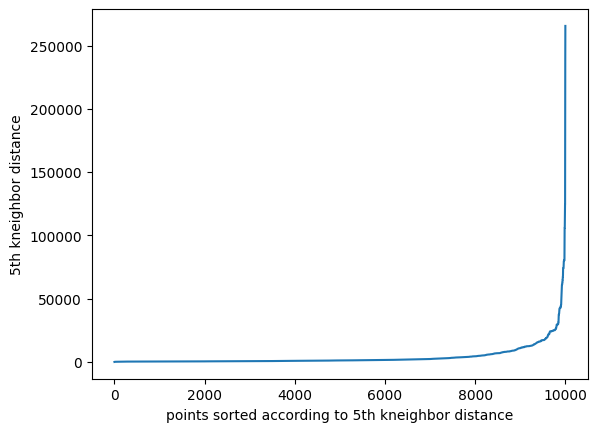

1827.2766

In [ ]:
slice = 10000
data = np.array(data_without_labels[:slice])
distances = pairwise_distances(data)
k_nearest_distances = distances[:, 4]
k_nearest_distances = np.sort(k_nearest_distances)
x = np.arange(0, slice);
plt.plot(x, k_nearest_distances)
plt.xlabel("points sorted according to 5th kneighbor distance")
plt.ylabel("5th kneighbor distance")
plt.show()
np.average(k_nearest_distances[:9000])

In [ ]:


labels_m = train_test_split(labels, train_size=0.0015, random_state=42, stratify=labels)[0]
data_m = train_test_split(data_without_labels, train_size=0.0015, random_state=42, stratify=labels)[0]
labels_m, dict = convert_string_to_numeric(pd.DataFrame(labels_m))
labels_m = labels_m.values
labels_m = labels_m.reshape(labels_m.size)
counts = np.unique(labels_m, return_counts=True)[1]
dict = {value: key for key, value in dict.items()}
pred_labels = DBSCAN(np.array(data_m), epsilon=100, min_points=5)
dBSC = []
precision,_ = measure_precision(labels_m, pred_labels, dict)
recall = measure_recall(labels_m, pred_labels, counts)
f = measure_f1(labels_m, pred_labels, counts)
entropy = measure_entropy(labels_m, pred_labels);
dBSC.append(precision)
dBSC.append(recall)
dBSC.append(f)
dBSC.append(entropy)
result["DBSCAN"] = dBSC
print("f-score =", f)
print("precision =",precision)
     


f-score = 0.2378003130385976
precision = 0.9857033924243117


In [ ]:
def find_best_epsilon(data, labels):
  epsion = 100
  max_f1_score = 0
  for e in range(100, 2000, 100):
    pred_labels = DBSCAN(data, epsilon=e, min_points=5)
    f1 = measure_f1(labels, pred_labels, counts)
    if f1 > max_f1_score:
      max_f1_score = f1
      epsilon = e
  return epsion

epsion = find_best_epsilon(np.array(data_m), labels_m)

<a name="7"></a>
## 7- Clustering Evaluation

<a name="7.1"></a>
### 7.1 - getting predicted labels

In [ ]:
result = pd.DataFrame()

In [ ]:
c_labels = spectral_clustering(data_without_labels, 11)
unique_elements, counts = np.unique(c_labels, return_counts=True)
print(unique_elements, counts)

(0,) 1511.485


/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 0  1  2  3  4  5  6  7  8  9 10] [ 542  919 1301 1431  441  306  364  421  618  670  334]


In [ ]:
# run this line in spectral clustering 
labels_m = train_test_split(labels, train_size=0.0015, random_state=42, stratify=labels)[0]
labels_m, dict = convert_string_to_numeric(pd.DataFrame(labels_m))
labels_m = labels_m.values
labels_m = labels_m.reshape(labels_m.size)
counts = np.unique(labels_m, return_counts=True)[1]
dict = {value: key for key, value in dict.items()}

<a name="7.2"></a>
### 7.2 - Recall Measure


In [ ]:
def measure_recall(real_labels, predicted_labels, counts):
  sum = 0;
  unique_predic = np.unique(predicted_labels)
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    major_class = mode(cluster, axis=None, keepdims=True)
    #print(major_class.count[0] / counts[major_class.mode[0]])
    sum += major_class.count[0] / counts[major_class.mode[0]]
  return sum / unique_predic.size

# print(measure_recall(labels, c_labels))

<a name="7.3"></a>
### 7.3 - Precision Measure

In [ ]:
def measure_precision(real_labels, predicted_labels, dict):
  rev_dict = {value: key for key, value in dict.items()}
  normal_idx = rev_dict['normal.']
  # print(normal_idx)
  sum = 0;
  unique_predic = np.unique(predicted_labels)
  anomalies = [] #anomaly_major_name, percentage, number, percentage_of_normal 
  for c_label in unique_predic:
    class_cur = np.count_nonzero(predicted_labels == c_label)
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    major_class = mode(cluster, axis=None, keepdims=True)
    anomaly = [dict[major_class.mode[0]], class_cur]
    if major_class.mode[0] != normal_idx:
      anomaly.append(np.count_nonzero(cluster == normal_idx))
    else:
      anomaly.append(np.count_nonzero(cluster != normal_idx)) 
      # anomaly.append("normal") 
    anomalies.append(anomaly)
    sum += major_class.count[0] / cluster.size
  return sum / unique_predic.size, anomalies
# print(measure_precision(labels, c_labels))

<a name="7.4"></a>
### 7.4 F1 Score

In [ ]:
def measure_f1(real_labels, predicted_labels,counts):
  sum = 0;
  unique_predic = np.unique(predicted_labels)
  #print(unique_predic)
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    major_class = mode(cluster, axis=None, keepdims=True)
    #print(major_class.count[0] / cluster.size, ", ", major_class.count[0] / counts[major_class.mode[0]])
    recall = major_class.count[0] / counts[major_class.mode[0]]
    precis = major_class.count[0] / cluster.size
    sum += (2 * recall * precis) / (recall + precis)
  return sum / unique_predic.size
# print(measure_f1(labels, c_labels))

<a name="#7.5"></a>
### 7.5 Conditional Entropy

In [ ]:
def measure_entropy(real_labels, predicted_labels):
  unique_predic = np.unique(predicted_labels)
  total_entropy = 0
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    probs_in_cluster = np.unique(cluster, return_counts = True)[1] / cluster.size
    probs_in_cluster = probs_in_cluster * np.log2(probs_in_cluster) 
    cluster_cond_entropy = -np.sum(probs_in_cluster)
    #print(cluster_cond_entropy)
    total_entropy += (cluster.size / real_labels.size * cluster_cond_entropy)
  return total_entropy
# print(measure_entropy(labels, c_labels))

In [ ]:
def test_spectral(labels, predicted_labels, dict, counts):
  print('for Spectral Clustering')
  
  spectral_clustering = []
  precision, clusters = measure_precision(labels, predicted_labels, dict)
  spectral_clustering.append(precision)
  print(f'precision:\n {precision}')
  recall = measure_recall(labels, predicted_labels, counts)
  spectral_clustering.append(recall)
  print(f'recall:\n {recall}')
  f1 = measure_f1(labels, predicted_labels, counts)
  spectral_clustering.append(f1)
  print(f'f1:\n {f1}')
  entropy = measure_entropy(labels, predicted_labels);
  spectral_clustering.append(entropy)
  print(f'entropy:\n {entropy}')
  print(spectral_clustering)
  result["spectral_clustering"] = spectral_clustering
  return clusters

spectural_cluster=test_spectral(labels_m, c_labels, dict, counts)

for Spectral Clustering
precision:
 0.8077109180695462
recall:
 0.2244267691468803
f1:
 0.3227787727064549
entropy:
 0.6477989001706913
[0.8077109180695462, 0.2244267691468803, 0.3227787727064549, 0.6477989001706913]


In [ ]:
def testKmeans(kmean, labels,data):
    pL=kmean.predict(data)
    kmean_data_frame = pd.DataFrame(pL)
    kmean_data_frame.columns = ["labels"]
    labels, dict = convert_string_to_numeric(pd.DataFrame(labels))
    dict = {value: key for key, value in dict.items()}
    labels = labels.values
    labels = labels.reshape(labels.size)
    print(labels)
    counts = np.unique(labels, return_counts=True)[1]
    print("Kmean prediction result")
    print("Kmean recall result")
    recall = measure_recall(labels,pL,counts)
    print(recall)
    print("Kmean precision result")
    precision = measure_precision(labels, pL, dict)
    print(precision[0])
    print("Kmean f1 result")
    f1 = measure_f1(labels, pL,counts)
    print(f1)
    print("Kmean entropy result")
    entropy = measure_entropy(labels, pL)
    print(entropy)
    return recall,precision[0],f1,entropy,precision[1]

In [ ]:
testKmeans(kmean_7, labels_10,data_10_numeric)

[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.40062658861758205
Kmean precision result
0.8549044696583108
Kmean f1 result
0.37040656515923936
Kmean entropy result
1.5157283006743116


(0.40062658861758205,
 0.8549044696583108,
 0.37040656515923936,
 1.5157283006743116,
 [['normal.', 21, 1],
  ['normal.', 76, 3],
  ['warezmaster.', 18, 3],
  ['warezclient.', 82, 22],
  ['smurf.', 491482, 97008],
  ['back.', 2341, 152],
  ['portsweep.', 1, 0]])

Test all k in kmean

In [ ]:
def tesK():
    DATASET_COLUMNS_FILE = "/home/elsaber/pr assign/cluster/kddcup1999_columns.txt"
    column_types =[]
    with open(DATASET_COLUMNS_FILE, 'r') as file:
        column_labels: str = file.read()
    column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
    for column_type in column_labels.splitlines()[:]:
        match = column_regex.match(column_type)
        column_types.append(match.group("column_name"))
    test_data = pd.read_csv("/home/elsaber/pr assign/cluster/kddcup.data.corrected", header=None)
    test_data.columns = column_types
    data_without_labels = test_data.drop(columns=["class"])
    labels = test_data["class"]
    data_numeric = convert_string_to_binary_numeric(data_without_labels)
    recalls = []
    precisions = []
    f1s = []
    entropies =[]
    clusters = []
    ans = testKmeans(kmean_7, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    clusters.append(ans[4])
    result["7 means"] = [ans[1],ans[0],ans[2],ans[3]]
    ans = testKmeans(kmean_15, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    clusters.append(ans[4])
    result["15 means"] = [ans[1],ans[0],ans[2],ans[3]]
    ans = testKmeans(kmean_23, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    clusters.append(ans[4])
    result["23 means"] = [ans[1],ans[0],ans[2],ans[3]]
    ans = testKmeans(kmean_31, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    clusters.append(ans[4])
    result["31 means"] = [ans[1],ans[0],ans[2],ans[3]]
    ans = testKmeans(kmean_45, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    clusters.append(ans[4])
    result["45 means"] = [ans[1],ans[0],ans[2],ans[3]]
    del test_data
    return recalls,precisions,f1s,entropies,clusters


In [ ]:
recalls,precisions,f1s,entropies,kmean_cluseter = tesK()

[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.39216723639986373
Kmean precision result
0.7737194995230797
Kmean f1 result
0.2922778454327299
Kmean entropy result
1.4810960460543539
[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.2694027574639399
Kmean precision result
0.8846473896687176
Kmean f1 result
0.24023916939634263
Kmean entropy result
0.5212680754187011
[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.2277110439810361
Kmean precision result
0.9313407288608586
Kmean f1 result
0.23958713179218924
Kmean entropy result
0.2830289449963907
[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.17874019111220876
Kmean precision result
0.9486941930654974
Kmean f1 result
0.21117855298580052
Kmean entropy result
0.06256741610713963
[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.1237752120868995
Kmean precision result
0.94897922454209
Kmean f1 result
0.15745475584507265
Kmean entropy result
0.05084429874278061


In [ ]:
result

,spectral_clustering,7 means,15 means,23 means,31 means,45 means,DBSCAN
0,0.807711,0.773719,0.884647,0.931341,0.948694,0.948979,0.985703
1,0.224427,0.392167,0.269403,0.227711,0.178740,0.123775,0.194479
2,0.322779,0.292278,0.240239,0.239587,0.211179,0.157455,0.237800
3,0.647799,1.481096,0.521268,0.283029,0.062567,0.050844,0.257182


In [ ]:
k = [7,15,23,31,45]


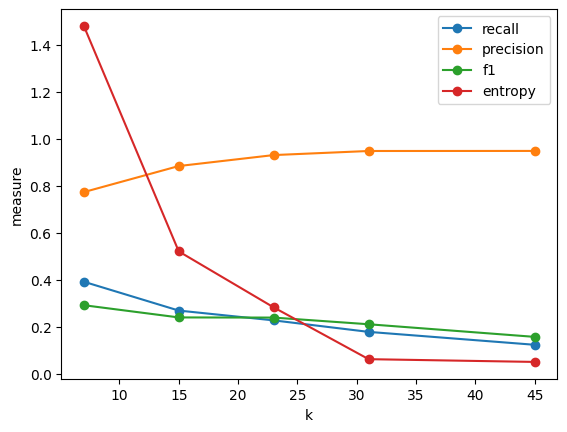

In [ ]:
plt.plot(k, recalls, '-o')
plt.plot(k, precisions, '-o')
plt.plot(k, f1s, '-o')
plt.plot(k, entropies, '-o')
plt.legend(["recall","precision","f1", "entropy"])
plt.xlabel('k')
plt.ylabel('measure')
plt.show()

In [ ]:
def calcError(cluster):
    new_list = [row[1:] for row in cluster]
    my_array = np.array(new_list )

    row_sums = my_array.sum(axis =0)
    error =row_sums[1]  / row_sums[0]
    return error

Error Calculation

In [ ]:

error = calcError(kmean_cluseter[0])
print(f"7 means error {error}")
error = calcError(kmean_cluseter[1])
print(f"15 means error {error}")
error = calcError(kmean_cluseter[2])
print(f"23 means error {error}")
error = calcError(kmean_cluseter[3])
print(f"31 means error {error}")
error = calcError(kmean_cluseter[4])
print(f"45 means error {error}")
error = calcError(spectural_cluster)
print(f"spectural_cluster error {error}")

7 means error 0.19839638447494717
15 means error 0.13989601976632926
23 means error 0.06547953824398058
31 means error 0.005514214653630928
45 means error 0.01082999842194368
spectural_cluster error 0.046549612086565946


Number of anomalies

In [ ]:
kmean_cluseter

[[['normal.', 178, 1],
  ['normal.', 593, 3],
  ['warezmaster.', 32, 14],
  ['normal.', 313, 63],
  ['smurf.', 4893571, 970200],
  ['back.', 3739, 1550],
  ['portsweep.', 5, 0]],
 [['normal.', 494, 1],
  ['normal.', 1243, 1],
  ['normal.', 61928, 6],
  ['normal.', 169735, 324],
  ['neptune.', 1699814, 585760],
  ['smurf.', 2904509, 96539],
  ['normal.', 16931, 4],
  ['normal.', 5556, 809],
  ['normal.', 33877, 203],
  ['warezmaster.', 32, 14],
  ['normal.', 140, 0],
  ['normal.', 121, 3],
  ['back.', 3733, 1544],
  ['portsweep.', 5, 0],
  ['normal.', 313, 63]],
 [['normal.', 5559, 809],
  ['normal.', 12535, 3],
  ['normal.', 33864, 203],
  ['normal.', 35057, 4],
  ['normal.', 70445, 16],
  ['normal.', 141128, 304],
  ['normal.', 268576, 16],
  ['neptune.', 1412688, 312118],
  ['satan.', 13270, 10],
  ['normal.', 983, 0],
  ['warezmaster.', 32, 14],
  ['normal.', 118, 3],
  ['normal.', 138, 0],
  ['normal.', 471, 1],
  ['normal.', 72936, 269],
  ['smurf.', 126908, 4178],
  ['smurf.', 40

In [ ]:
def number_of_anomalies(cluster):
    anomalies = 0
    f_anomalies_predict = 0
    t_anomalies_not_predict = 0
    for index, row in enumerate(cluster):
        if row[0] != 'normal.':
            anomalies +=row[1]
            f_anomalies_predict +=  row[2]
        else:
           t_anomalies_not_predict += row[2] 
    return anomalies,f_anomalies_predict,t_anomalies_not_predict

In [ ]:
spectural_cluster

[['smurf.', 542, 9],
 ['smurf.', 919, 3],
 ['normal.', 1301, 92],
 ['smurf.', 1431, 9],
 ['neptune.', 441, 59],
 ['neptune.', 306, 25],
 ['smurf.', 364, 13],
 ['neptune.', 421, 74],
 ['smurf.', 618, 19],
 ['smurf.', 670, 3],
 ['neptune.', 334, 36]]

In [ ]:
anomalies,not_anomalies_but_predicted_anomaly,anomalies_but_not_predicte = number_of_anomalies(kmean_cluseter[0])
print(f"7 kmean number of predicted anomalies {anomalies} predicted anomaly wrong {not_anomalies_but_predicted_anomaly} not predicted anomaly wrong {anomalies_but_not_predicte}")
anomalies,not_anomalies_but_predicted_anomaly,anomalies_but_not_predicte = number_of_anomalies(kmean_cluseter[1])
print(f"15 kmean number of predicted anomalies {anomalies} predicted anomaly wrong {not_anomalies_but_predicted_anomaly} not predicted anomaly wrong {anomalies_but_not_predicte}")
anomalies,not_anomalies_but_predicted_anomaly,anomalies_but_not_predicte = number_of_anomalies(kmean_cluseter[2])
print(f"23 kmean number of predicted anomalies {anomalies} predicted anomaly wrong {not_anomalies_but_predicted_anomaly} not predicted anomaly wrong {anomalies_but_not_predicte}")
anomalies,not_anomalies_but_predicted_anomaly,anomalies_but_not_predicte = number_of_anomalies(kmean_cluseter[3])
print(f"31 kmean number of predicted anomalies {anomalies} predicted anomaly wrong {not_anomalies_but_predicted_anomaly} not predicted anomaly wrong {anomalies_but_not_predicte}")
anomalies,not_anomalies_but_predicted_anomaly,anomalies_but_not_predicte = number_of_anomalies(kmean_cluseter[4])
print(f"45 kmean number of predicted anomalies {anomalies} predicted anomaly wrong {not_anomalies_but_predicted_anomaly} not predicted anomaly wrong {anomalies_but_not_predicte}")
anomalies,not_anomalies_but_predicted_anomaly,anomalies_but_not_predicte = number_of_anomalies(spectural_cluster)
print(f"spectural cluster number of predicted anomalies {anomalies} predicted anomaly wrong {not_anomalies_but_predicted_anomaly} not predicted anomaly wrong {anomalies_but_not_predicte}")


7 kmean number of predicted anomalies 4897347 predicted anomaly wrong 971764 not predicted anomaly wrong 67
15 kmean number of predicted anomalies 4608093 predicted anomaly wrong 683857 not predicted anomaly wrong 1414
23 kmean number of predicted anomalies 4242903 predicted anomaly wrong 319000 not predicted anomaly wrong 1747
31 kmean number of predicted anomalies 3914431 predicted anomaly wrong 7896 not predicted anomaly wrong 19115
45 kmean number of predicted anomalies 3875600 predicted anomaly wrong 1500 not predicted anomaly wrong 51550
spectural cluster number of predicted anomalies 6046 predicted anomaly wrong 250 not predicted anomaly wrong 92
